In [20]:
from PIL import Image
import numpy as np
from pathlib import Path
import random, math
import matplotlib.pyplot as plt

In [21]:
# ========== CONFIG ==========
# Image path on local machine
INPUT_IMAGES = [
    "/Users/kate/Documents/retina-model/Image-set-1/apple1.png",
    "/Users/kate/Documents/retina-model/Image-set-1/apple2.png",
    "/Users/kate/Documents/retina-model/Image-set-1/apple3.png",
    "/Users/kate/Documents/retina-model/Image-set-1/baby1.png",
    "/Users/kate/Documents/retina-model/Image-set-1/baby2.png",
    "/Users/kate/Documents/retina-model/Image-set-1/baby3.png",
    "/Users/kate/Documents/retina-model/Image-set-1/face1.png",
    "/Users/kate/Documents/retina-model/Image-set-1/face2.png",
    "/Users/kate/Documents/retina-model/Image-set-1/face3.png",
    "/Users/kate/Documents/retina-model/Image-set-1/flower1.png",
    "/Users/kate/Documents/retina-model/Image-set-1/flower2.png",
    "/Users/kate/Documents/retina-model/Image-set-1/flower3.png",
]

In [23]:
OUT_DIR = Path("/Users/kate/Documents/retina-model/Image-set-1/transformed-images")
OUT_DIR.mkdir(parents=True, exist_ok=True)

CANVAS  = 256                 # final image size
MARGIN  = 5                   # require ≥ 5 px white border after transforms
THRESH  = 128                 # gray < THRESH -> black (object)

SIZE_MIN, SIZE_MAX   = 128, 192    # random target max dimension (inclusive)
ANGLE_MIN, ANGLE_MAX = -60.0, 60.0 # rotation range
SHIFT_MIN, SHIFT_MAX = 3, 15       # translation distance range (px)

N_SAMPLES_PER_IMAGE  = 20
MAX_ROTATION_TRIES   = 50
MAX_SHIFT_TRIES      = 50

# Optional reproducibility:
random.seed(42)


In [24]:
# ========== HELPERS ==========
def load_rgb_white_bg(path):
    """Open image; composite alpha (if any) over white; return RGB."""
    img = Image.open(path)
    if img.mode in ("RGBA", "LA") or ("transparency" in img.info):
        rgba = img.convert("RGBA")
        white = Image.new("RGBA", rgba.size, (255, 255, 255, 255))
        img = Image.alpha_composite(white, rgba).convert("RGB")
    else:
        img = img.convert("RGB")
    return img

def to_mask(img_rgb):
    """RGB -> boolean mask (True = object) by simple luminance threshold."""
    arr = np.array(img_rgb, dtype=np.uint8)
    gray = arr.mean(axis=2)
    return (gray < THRESH)

def bbox(mask):
    """Tight bbox (r0,r1,c0,c1) of True pixels, or None if empty."""
    rows = np.where(mask.any(axis=1))[0]
    cols = np.where(mask.any(axis=0))[0]
    if rows.size == 0 or cols.size == 0:
        return None
    return int(rows[0]), int(rows[-1]), int(cols[0]), int(cols[-1])

def resize_mask_to_max(mask, target_max):
    """Scale boolean mask so max(height,width) == target_max (NEAREST keeps binary)."""
    h, w = mask.shape
    if h >= w:
        new_h = target_max
        new_w = max(1, int(round(w * (target_max / h))))
    else:
        new_w = target_max
        new_h = max(1, int(round(h * (target_max / w))))
    mL = Image.fromarray(np.uint8(mask) * 255)  # let Pillow infer mode
    mL = mL.resize((new_w, new_h), resample=Image.NEAREST)
    return np.array(mL) > 0

def center_on_canvas(mask, size=CANVAS):
    """Center a (tight) mask on a size×size canvas."""
    H, W = mask.shape
    out = np.zeros((size, size), dtype=bool)
    y0 = (size - H) // 2
    x0 = (size - W) // 2
    out[y0:y0+H, x0:x0+W] = mask
    return out

def ensure_margin(mask, margin=MARGIN):
    """Check ≥ margin white pixels from object bbox to each image edge."""
    bb = bbox(mask)
    if bb is None:
        return True
    r0, r1, c0, c1 = bb
    top    = r0
    bottom = (mask.shape[0] - 1) - r1
    left   = c0
    right  = (mask.shape[1] - 1) - c1
    return min(top, bottom, left, right) >= margin

def rotate_center(mask, angle_deg):
    """Rotate full 256×256 mask about center; keep size; NEAREST keeps binary."""
    mL = Image.fromarray(np.uint8(mask) * 255)
    mLr = mL.rotate(angle_deg, resample=Image.NEAREST, expand=False, fillcolor=0)
    return (np.array(mLr) > 0)

def translate_mask(mask, dx, dy):
    """Integer-translate mask by dx (right +), dy (down +), clipped to canvas."""
    H, W = mask.shape
    out = np.zeros_like(mask)
    x0s, x1s = max(0, -dx), min(W, W - dx)
    y0s, y1s = max(0, -dy), min(H, H - dy)
    x0d, x1d = max(0,  dx), min(W, W + dx)
    y0d, y1d = max(0,  dy), min(H, H + dy)
    if x1s > x0s and y1s > y0s:
        out[y0d:y1d, x0d:x1d] = mask[y0s:y1s, x0s:x1s]
    return out

def render(mask):
    """Boolean mask -> RGB image (black object on white)."""
    H, W = mask.shape
    img = Image.new("RGB", (W, H), (255, 255, 255))
    obj = Image.new("RGB", (W, H), (0, 0, 0))
    mL = Image.fromarray(np.uint8(mask) * 255)
    img.paste(obj, (0, 0), mask=mL)
    return img

In [25]:
# ========== PIPELINE  ==========
records = []   # stats for plotting
total = 0
classes_in_order = [Path(p).stem for p in INPUT_IMAGES]  # 12 class labels (one per original image)
class_to_index = {c: i for i, c in enumerate(classes_in_order)}

for path in INPUT_IMAGES:
    src = Path(path)
    base_img  = load_rgb_white_bg(src)
    base_mask = to_mask(base_img)

    bb = bbox(base_mask)
    if bb is None:
        print(f"WARNING: {src.name}: no object detected; skipped.")
        continue

    r0, r1, c0, c1 = bb
    tight = base_mask[r0:r1+1, c0:c1+1]

    for k in range(1, N_SAMPLES_PER_IMAGE + 1):
        # 1) random scale + center
        target_max = int(random.randint(SIZE_MIN, SIZE_MAX))
        mask_sized  = resize_mask_to_max(tight, target_max)
        mask_center = center_on_canvas(mask_sized, CANVAS)

        # 2) rotation accept/reject
        angle = None
        for _ in range(MAX_ROTATION_TRIES):
            a = random.uniform(ANGLE_MIN, ANGLE_MAX)
            mr = rotate_center(mask_center, a)
            if ensure_margin(mr, MARGIN):
                angle = a
                mask_rot = mr
                break
        if angle is None:
            angle = 0.0
            mask_rot = mask_center
            if not ensure_margin(mask_rot, MARGIN):
                print(f"WARNING: {src.name} [sample {k}]: no rotation with margin; using 0°.")

        # 3) translation accept/reject
        dx = dy = None
        for _ in range(MAX_SHIFT_TRIES):
            r = random.uniform(SHIFT_MIN, SHIFT_MAX)
            theta = random.uniform(0.0, 2.0 * math.pi)
            tx = int(round(r * math.cos(theta)))
            ty = int(round(r * math.sin(theta)))
            if tx == 0 and ty == 0:
                continue
            mt = translate_mask(mask_rot, tx, ty)
            if ensure_margin(mt, MARGIN):
                dx, dy = tx, ty
                mask_final = mt
                break
        if dx is None:
            dx, dy = 0, 0
            mask_final = mask_rot
            if not ensure_margin(mask_final, MARGIN):
                print(f"WARNING: {src.name} [sample {k}]: no translation with margin; saving w/o translation.")

        # 4) save image
        angle_tag = f"{int(round(angle)):+03d}"
        dx_tag    = f"{dx:+03d}"
        dy_tag    = f"{dy:+03d}"
        out_name  = f"{src.stem}_n{k:02d}_s{target_max}_rot{angle_tag}_dx{dx_tag}_dy{dy_tag}.png"
        out_path  = OUT_DIR / out_name
        render(mask_final).save(out_path, "PNG")
        total += 1

        # 5) collect stats for dot plots
        cls = src.stem
        area = int(np.count_nonzero(mask_final))  # number of object pixels
        rot_deg = float(angle)
        trans_dist = float(math.hypot(dx, dy))
        # Direction in degrees [0, 360)
        trans_dir_deg = (math.degrees(math.atan2(dy, dx)) + 360.0) % 360.0

        records.append({
            "class": cls,
            "sample": k,
            "max_dim": target_max,
            "area_px": area,
            "rotation_deg": rot_deg,
            "translation_dist": trans_dist,
            "translation_dir_deg": trans_dir_deg,
        })

print(f"Done. Wrote {total} transformed 256×256 black/white PNGs to: {OUT_DIR}")

Done. Wrote 240 transformed 256×256 black/white PNGs to: /Users/kate/Documents/retina-model/Image-set-1/transformed-images


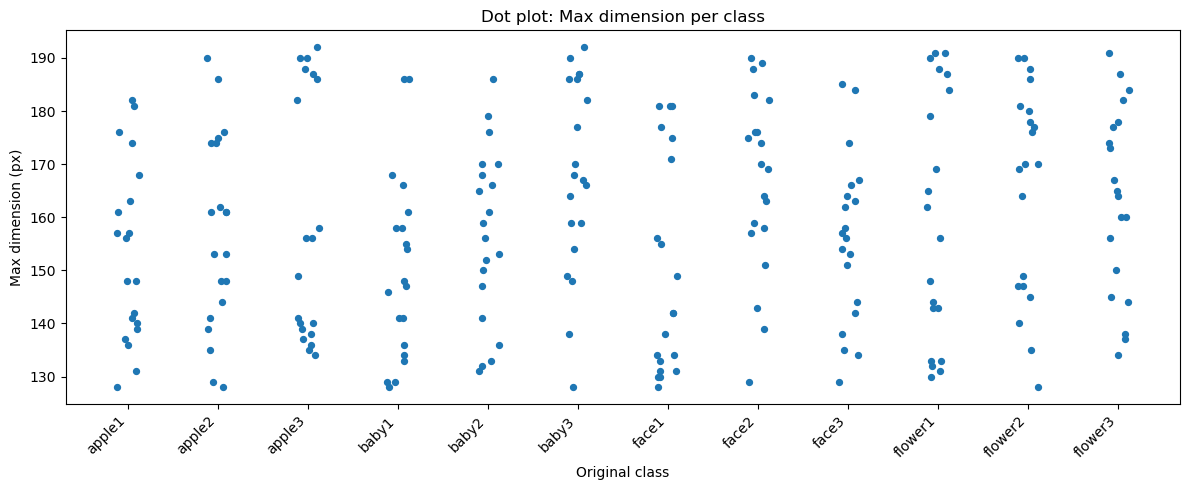

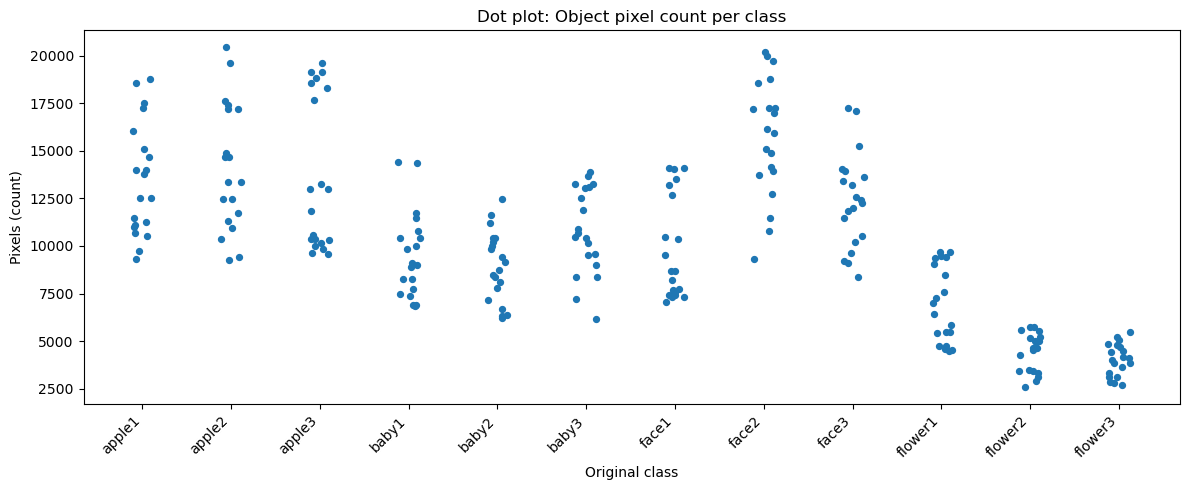

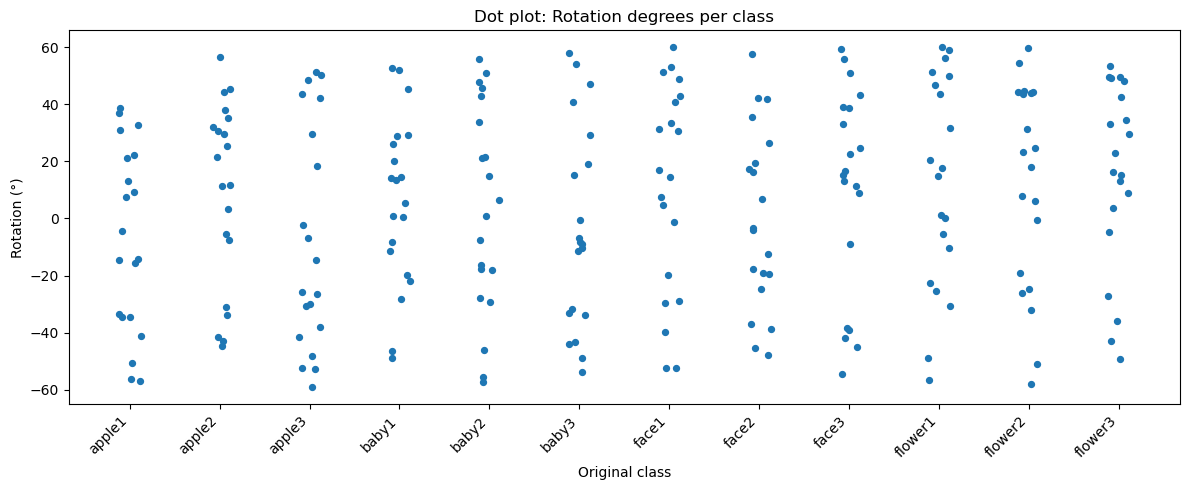

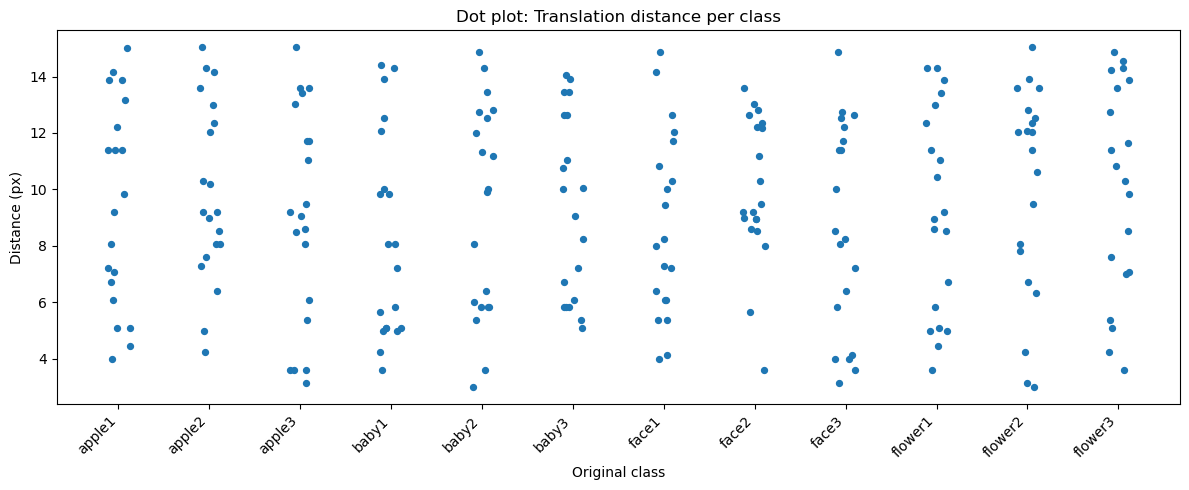

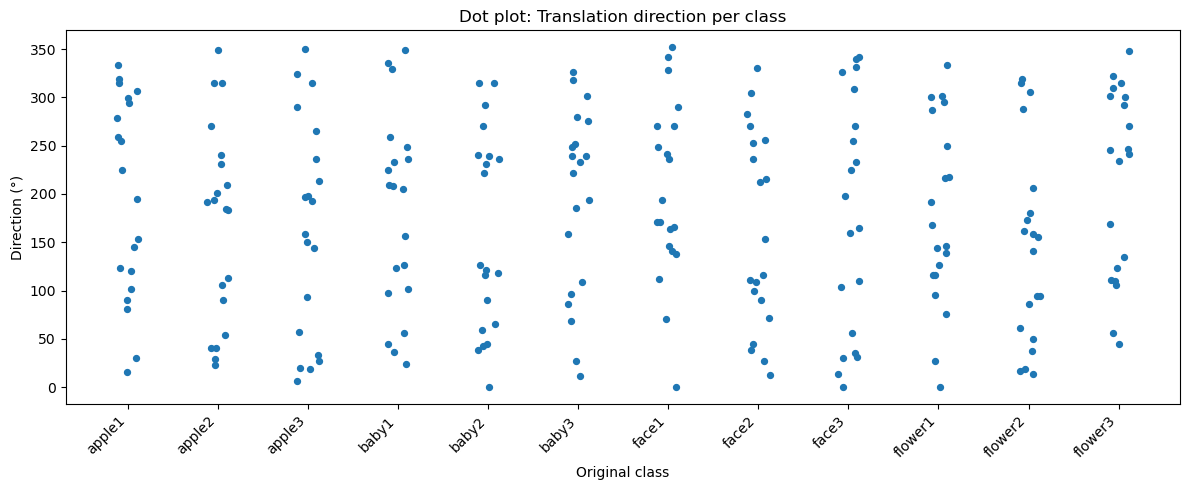

In [26]:
# ========== DOT PLOTS ==========
# Helper: generic category dot-plot with jitter
def dotplot_by_class(records, classes, key, title, ylabel):
    x_index = {c: i for i, c in enumerate(classes)}
    xs, ys = [], []
    for r in records:
        xs.append(x_index[r["class"]] + (np.random.rand() - 0.5) * 0.25)  # small jitter
        ys.append(r[key])
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.scatter(xs, ys, s=18)
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Original class")
    plt.tight_layout()
    plt.show()

# 1) Max dimension (target_max)
dotplot_by_class(records, classes_in_order, "max_dim",
                 "Dot plot: Max dimension per class", "Max dimension (px)")

# 2) Number of pixels (object area)
dotplot_by_class(records, classes_in_order, "area_px",
                 "Dot plot: Object pixel count per class", "Pixels (count)")

# 3) Rotation degrees
dotplot_by_class(records, classes_in_order, "rotation_deg",
                 "Dot plot: Rotation degrees per class", "Rotation (°)")

# 4) Translation distance
dotplot_by_class(records, classes_in_order, "translation_dist",
                 "Dot plot: Translation distance per class", "Distance (px)")

# 5) Translation direction (0–360°)
dotplot_by_class(records, classes_in_order, "translation_dir_deg",
                 "Dot plot: Translation direction per class", "Direction (°)")

/Users/kate/anaconda_projects/7bd8b58a-5353-4f1d-8460-77cbb73fcbb8
